In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [2]:
import tensorflow as tf

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [4]:
!ls /Users/adwiz/.keras/datasets/

cats_and_dogs_filtered      fashion-mnist
cats_and_dogs_filterted.zip mnist.npz


In [5]:
# определим папки с данными
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [6]:
num_cats_tr = len(list(train_cats_dir.glob("*"))) # .glob("*") создает итератор по всем файлам в директории
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


(378, 500, 3)
(225, 299, 3)


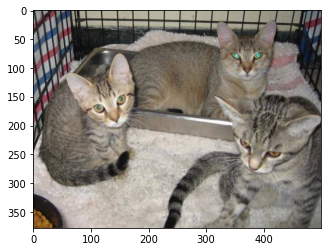

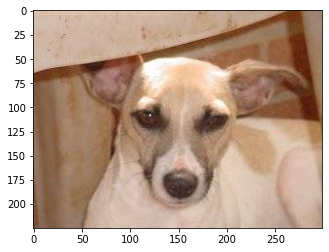

In [8]:
# взглянем на несколько картинок глазами

image_path = str(list(validation_cats_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

image_path = str(list(validation_dogs_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

Для дальнейшей работы мы должны реализовать код, который делает следующее:

1.  Считывает картинку с диска
2.  Приводит ее к заранее определенному размеру (IMAGE_SIZE, IMAGE_SIZE)
3.  Нормализует значения пикселей (делением на 255)
4.  Как только считано BATCH_SIZE картинок -- превратить их в четырехмерный тензор размера (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3) и подать на вход сети вместе с соотвествтующими им классами

In [9]:
BATCH_SIZE = 100 # размер батча -- т.е. количество картинок которые мы считываем за раз
                 # во многом зависит от доступной памяти GPU. 
                 # Если ее не хватит (появится такая ошибка) значит нужно уменьшить размер батча или картинки
IMG_SHAPE  = 150 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator?

параметр rescale отвечает за нормализацию значений пикселей, а именно за умножение их на число - в нашем случае на 1./255
определив ImageDataGenerator мы сообщаем Keras что мы хотим сделать с картинкой после того как мы считали её с диска.
Определим генераторы для трейна и валидации.

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

Теперь мы должны сообщить откуда и по сколько картинок мы хотим считывать. Для этого у ImageDataGenerator существует два метода:
flow_from_directory и flow_from_dataframe. Первый ожидает определенную структуру папок из которых он сам поймет к каким классам
изображения относятся - как в нашем случае. Второй работет с датафреймом где указаны пути до изображений и соответствующие им классы.
Т.к. наши данные уже в правильном виде - воспользуемся для просмотра первым подходом.

In [12]:
# train_image_generator.flow_from_directory?



```
train_image_generator.flow_from_directory(directory, target_size=(256, 256),class_mode='categorical', batch_size=32, shuffle=True, ...)
```


*   directory -- путь до корневой папки в которой расположены папки с названиями классов и в которых лежат изоражения. Т.е. именно тот формат в котором мы имеем наши данные (см. схему выше). В нашем случае мы должны передать путь до папки train и validation для каждого из генераторов.
*   target_size -- размер к которому будут приведены все изображения
*   class_mode -- режим меток класса
--     categorical -- onehot encoded (например для двух классов класс 0 -- [1, 0], класс 1 -- [0, 1]
--     binary -- класс числом -- 1 или 0
--     sparse -- класс числом для не бинарного случая
--     input -- "класс" -- само изображение
--     None  -- без класса
*   batch_size -- размер батча
*   shuffle  -- перемешивать ли данные. Рекомендуется это делать во время трейна, чтобы батчи были разнообразные, но не делать во время теста -- чтобы сохранять порядок.




In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir, # путь до папки train
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary') # так как у нас два класса

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir, # путь до папки val
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary') # так как у нас два класса

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# чтобы понять какой класс считается первым а какой вторым воспользуемся .class_indices
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

Взглянув на тип генератора, можно понять, что это итератор. А значит мы можем итерироваться по нему с помощью next()

In [15]:
type(train_data_gen)

keras.preprocessing.image.DirectoryIterator

In [16]:
sample_training_images, sample_labels = next(train_data_gen) # как только мы выполним эту команду, мы считаем 100 картинок
                                                             # с диска и преобразуем их к нужному формату
sample_training_images.shape, sample_labels.shape # 4х мерный тензор и верктор из меток класса

((100, 150, 150, 3), (100,))

In [17]:
sample_labels # т.к. мы использовали shuffle - в батче содержатся метки классов в случайном порядке

array([1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [18]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    names = {0: "Cat", 1: "Dog"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

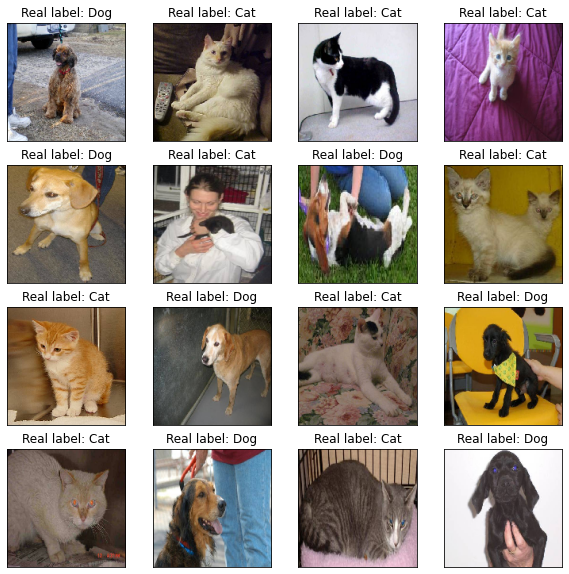

In [19]:
show_catsdogs(sample_training_images, sample_labels)
sample_training_images, sample_labels = next(train_data_gen)

# Оптимизация модели

In [20]:
# tf.debugging.set_log_device_placement(True)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# Global average pooling

In [22]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
tf.keras.layers.MaxPool2D(2, 2),

tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.MaxPool2D(2, 2),

tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
tf.keras.layers.MaxPool2D(2, 2),

tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
tf.keras.layers.MaxPool2D(2, 2),

tf.keras.layers.GlobalAveragePooling2D(), # добавили GAP
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy']
             )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [23]:
#!pip install livelossplot

In [24]:
from livelossplot.tf_keras import PlotLossesCallback

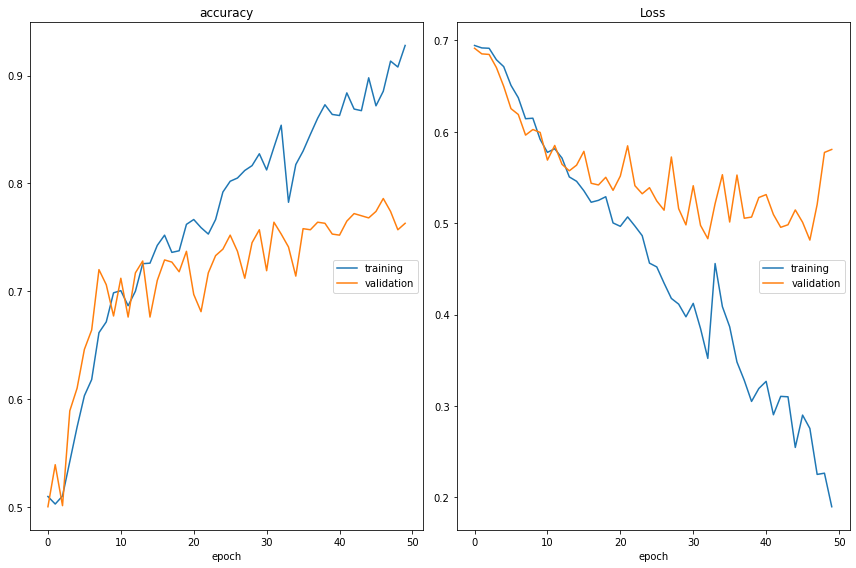

accuracy
	training         	 (min:    0.502, max:    0.928, cur:    0.928)
	validation       	 (min:    0.500, max:    0.786, cur:    0.763)
Loss
	training         	 (min:    0.190, max:    0.694, cur:    0.190)
	validation       	 (min:    0.482, max:    0.691, cur:    0.581)
20/20 [==============================] - 4s 205ms/step - loss: 0.1898 - accuracy: 0.9280 - val_loss: 0.5807 - val_accuracy: 0.7630


In [25]:
EPOCHS = 50
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

# Augmentation

In [26]:
# так выглядел наш прошлый генератор данных - он нормализовал изображения
image_gen_no_aug = ImageDataGenerator(rescale=1./255)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir, # путь до папки train
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary') # так как у нас два класса

Found 2000 images belonging to 2 classes.


In [27]:
# а теперь мы попросим его изменять изображение на лету, добавляя повороты, отражения и тд
image_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # максимальный угол поворота
    width_shift_range=.2, # смещение максимум на 20% ширины по горизонтали
    height_shift_range=.2, # смещение максимум на 20% высоты по вертикали
    zoom_range=.2, # картинка будет увеличена илм уменьшена не более чем на 20%
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы - сначала выберем черный цвет, а потом изменим на "nearest"
    #cval=0,
)

sample_aug = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=False,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


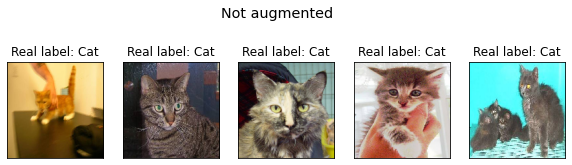

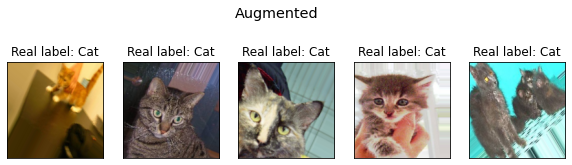

In [28]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(sample_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Augmented")

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.GlobalAveragePooling2D(), # добавили GAP
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [36]:
train_image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="nearest"
      ) 



train_data_gen = train_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


Found 2000 images belonging to 2 classes.


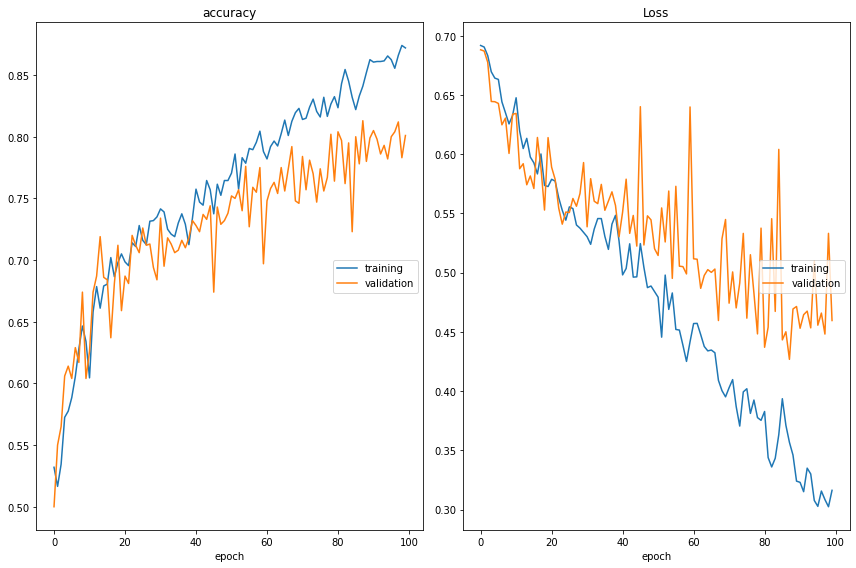

accuracy
	training         	 (min:    0.516, max:    0.874, cur:    0.872)
	validation       	 (min:    0.500, max:    0.813, cur:    0.801)
Loss
	training         	 (min:    0.302, max:    0.692, cur:    0.316)
	validation       	 (min:    0.427, max:    0.688, cur:    0.460)
20/20 [==============================] - 7s 341ms/step - loss: 0.3163 - accuracy: 0.8720 - val_loss: 0.4596 - val_accuracy: 0.8010


In [37]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]
)